In [1]:
# this step is required on Windows to avoid memory leak during KMeans
import os # dependency
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
from sklearn.datasets import fetch_olivetti_faces # dependency

In [3]:
data = fetch_olivetti_faces()
print(data.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [4]:
X = data.data
y = data.target

In [5]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (400, 4096)
y shape:  (400,)


In [6]:
# stratified sampling as there are only 10 instances per class
from sklearn.model_selection import StratifiedShuffleSplit # dependency

testSize = 0.2
valSize = 0.3 # wrt the 70% of the dataset

# train and test indexes
dataTrainTest = StratifiedShuffleSplit(n_splits=1, test_size=testSize, random_state=42)
trainIdx, testIdx = next(dataTrainTest.split(X, y))

# split based on the indexes
XtrainAndVal = X[trainIdx]
ytrainAndVal = y[trainIdx]

Xtest = X[testIdx]
ytest = y[testIdx]

# split the XtrainAnd Val into train and val
dataTrainVal = StratifiedShuffleSplit(n_splits=1, test_size=valSize, random_state=42)
trainIdx, valIdx = next(dataTrainVal.split(XtrainAndVal, ytrainAndVal))

Xtrain = XtrainAndVal[trainIdx]
ytrain = ytrainAndVal[trainIdx]

Xval = XtrainAndVal[valIdx]
yval = ytrainAndVal[valIdx]

In [7]:
print("Train size:", len(Xtrain)) 
print("Val size:  ", len(Xval)) 
print("Test size: ", len(Xtest)) 
print("Total size:", len(X)) 

Train size: 224
Val size:   96
Test size:  80
Total size: 400


In [8]:
# be sure that the splits are done correctly 
print("Class\t% in train\t% in val\t% in test")
for i in range(40):
    print(f" {i:2d}\t   {len(ytrain[ytrain == i]) / len(ytrain) * 100:.2f}" + 
          f"\t\t  {len(yval[yval == i]) / len(yval) * 100:.2f}" + 
          f"\t\t  {len(ytest[ytest == i]) / len(ytest) * 100:.2f}")

Class	% in train	% in val	% in test
  0	   2.68		  2.08		  2.50
  1	   2.68		  2.08		  2.50
  2	   2.23		  3.12		  2.50
  3	   2.23		  3.12		  2.50
  4	   2.68		  2.08		  2.50
  5	   2.68		  2.08		  2.50
  6	   2.68		  2.08		  2.50
  7	   2.23		  3.12		  2.50
  8	   2.68		  2.08		  2.50
  9	   2.68		  2.08		  2.50
 10	   2.23		  3.12		  2.50
 11	   2.68		  2.08		  2.50
 12	   2.68		  2.08		  2.50
 13	   2.68		  2.08		  2.50
 14	   2.23		  3.12		  2.50
 15	   2.68		  2.08		  2.50
 16	   2.68		  2.08		  2.50
 17	   2.68		  2.08		  2.50
 18	   2.23		  3.12		  2.50
 19	   2.68		  2.08		  2.50
 20	   2.23		  3.12		  2.50
 21	   2.23		  3.12		  2.50
 22	   2.23		  3.12		  2.50
 23	   2.23		  3.12		  2.50
 24	   2.68		  2.08		  2.50
 25	   2.68		  2.08		  2.50
 26	   2.68		  2.08		  2.50
 27	   2.68		  2.08		  2.50
 28	   2.23		  3.12		  2.50
 29	   2.68		  2.08		  2.50
 30	   2.23		  3.12		  2.50
 31	   2.68		  2.08		  2.50
 32	   2.23		  3.12		  2.50
 33	   2.68		  2.08		  2.50
 34	   2.68	

In [58]:
# the split seems good!
# time to cluster

from sklearn.cluster import KMeans # dependency

# train for a different amount of clusters 
modelsByK = []
ks = list(range(2, 153, 10))

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(Xtrain)
    modelsByK.append((k, model))

In [59]:
# get the silhouettes and intertias per k
from sklearn.metrics import silhouette_score # dependency
import numpy as np # dependency

silhouettes = np.array([[k, silhouette_score(X=Xtrain, labels=model.labels_)]
                        for k, model in modelsByK])
inertias = np.array([[k, model.inertia_]
                     for k, model in modelsByK])

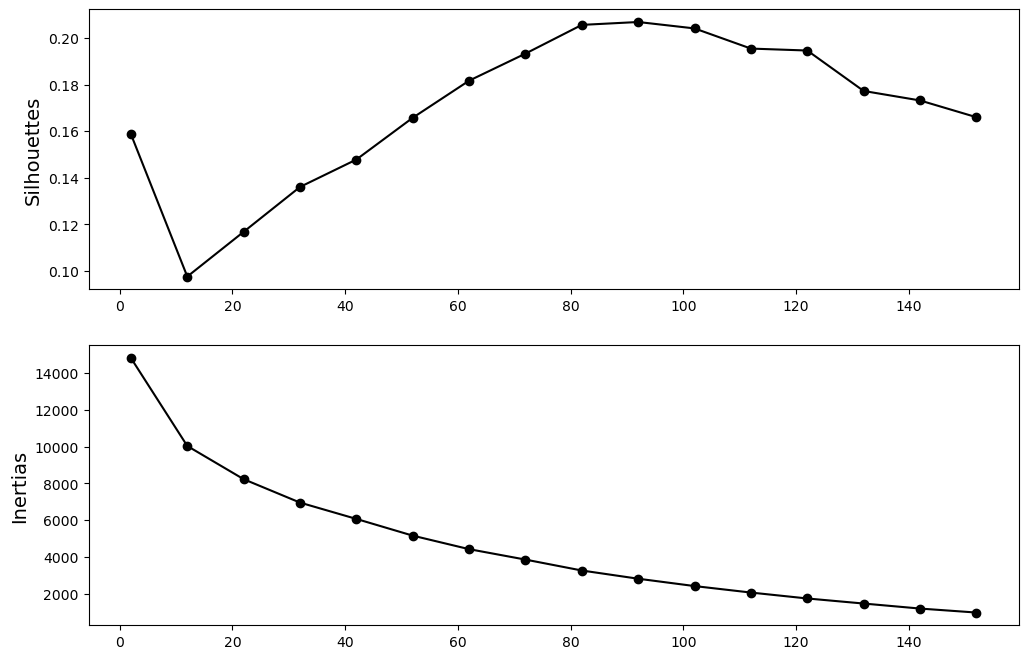

In [60]:
# plot the results
import matplotlib.pyplot as plt
plt.rc('axes', labelsize=14, titlesize=14)

plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(silhouettes[:, 0], silhouettes[:, 1], "ko-")
plt.ylabel("Silhouettes")

plt.subplot(212)
plt.plot(inertias[:, 0], inertias[:, 1], "ko-")
plt.ylabel("Inertias")

plt.show();

In [61]:
# the inertias are not useful as the plot doesn't show a significant elbow
# from the silhouettes plot, we know that the best k is close to 90

bestIndex = silhouettes[:, 1].argmax()
silhouettes[bestIndex]

array([92.        ,  0.20689197])

In [63]:
# we can run the previous code again but now just focusing on k: 80 < k < 100
# train for a different amount of clusters 
modelsByK = []
ks = list(range(80, 100, 2))

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(Xtrain)
    modelsByK.append((k, model))

silhouettes = np.array([[k, silhouette_score(X=Xtrain, labels=model.labels_)]
                        for k, model in modelsByK])

bestIndex = silhouettes[:, 1].argmax()
silhouettes[bestIndex]

array([96.        ,  0.20985295])

In [65]:
# usaremos k = 96 para el clustering